In [1]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [2]:
print(ee.__version__)
print(geemap.__version__)
ee.Initialize()

0.1.241
0.8.2


In [3]:
manaus_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)
info = manaus.geometry()
manaus = ee.Geometry(info)

atto_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_atto_footprint/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)
info = atto.geometry()
atto = ee.Geometry(info)

corumba_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_corumba_footprint/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)
info = corumba.geometry()
corumba = ee.Geometry(info)

mato_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_mato_footprint/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)
info = mato.geometry()
mato = ee.Geometry(info)

saop_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_saop_footprint/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)
info = saop.geometry()
saop = ee.Geometry(info)

In [4]:
#Select geom of interest to export
fc = manaus

In [5]:
# Read the ERA5 data 
# https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY

# Daily mean 2m air temperature
era5_2mt = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                   .select('mean_2m_air_temperature')
                   .filterBounds(fc)
                   .filter(ee.Filter.date('2016-01-01', '2019-12-31')))
#print(era5_2mt))

# Daily total precipitation sums
era5_tp = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                  .select('total_precipitation')
                  .filterBounds(fc)
                  .filter(ee.Filter.date('2016-01-01', '2019-12-31')))

# Daily mean 2m dewpoint temperature
era5_2d = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                  .select('dewpoint_2m_temperature')
                  .filterBounds(fc)
                  .filter(ee.Filter.date('2016-01-01', '2019-12-31')))

# Daily mean sea-level pressure
era5_mslp = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                    .select('mean_sea_level_pressure')
                    .filterBounds(fc)
                    .filter(ee.Filter.date('2016-01-01', '2019-12-31')))
# Convert pressure levels from Pa to hPa - Example for surface pressure
def era5_sp(image):
    return image.divide(100).set('system:time_start', image.get('system:time_start'))

# Daily mean surface pressure
era5_sp = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                  .select('surface_pressure')
                  .filterBounds(fc)
                  .filter(ee.Filter.date('2016-01-01', '2019-12-31'))).map(era5_sp)


# Daily mean 10m u-component of wind
era5_u_wind_10m = (ee.ImageCollection('ECMWF/ERA5/DAILY')
                          .select('u_component_of_wind_10m')
                          .filterBounds(fc)
                          .filter(ee.Filter.date('2016-01-01', '2019-12-31')))



In [6]:
# Visualization palette for total precipitation
visTp = {
  'min': 0,
  'max': 0.1,
  'palette': ['#FFFFFF', '#00FFFF', '#0080FF', '#DA00FF', '#FFA400', '#FF0000']
}

# Visualization palette for temperature (mean, min and max) and 2m dewpoint
# temperature
vis2mt = {
  'min': 250,
  'max': 320,
  'palette': [
    '#000080', '#0000D9', '#4000FF', '#8000FF', '#0080FF', '#00FFFF', '#00FF80',
    '#80FF00', '#DAFF00', '#FFFF00', '#FFF500', '#FFDA00', '#FFB000', '#FFA400',
    '#FF4F00', '#FF2500', '#FF0A00', '#FF00FF'
  ]
}

# Visualization palette for u- and v-component of 10m wind
visWind = {
  'min': 0,
  'max': 30,
  'palette': [
    '#FFFFFF', '#FFFF71', '#DEFF00', '#9EFF00', '#77B038', '#007E55', '#005F51',
    '#004B51', '#013A7B', '#023AAD'
  ]
}

# Visualization palette for pressure (surface pressure, mean sea level
# pressure) - adjust min and max values for mslp to min:990 and max:1050
visPressure = {
  'min': 500,
  'max': 1150,
  'palette': [
    '#01FFFF', '#058BFF', '#0600FF', '#DF00FF', '#FF00FF', '#FF8C00', '#FF8C00'
  ]
}


In [7]:
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 10)
Map

Map(center=[-2.609097222, -60.20929722], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [8]:
# Add layer to map
Map.addLayer(
    era5_tp.filter(ee.Filter.date('2019-07-15')), visTp,
    'Daily total precipitation sums')
Map.addLayer(
    era5_2d.filter(ee.Filter.date('2019-07-15')), vis2mt,
    'Daily mean 2m dewpoint temperature')
Map.addLayer(
    era5_2mt.filter(ee.Filter.date('2019-07-15')), vis2mt,
    'Daily mean 2m air temperature')
Map.addLayer(
    era5_u_wind_10m.filter(ee.Filter.date('2019-07-15')), visWind,
    'Daily mean 10m u-component of wind')
Map.addLayer(
    era5_sp.filter(ee.Filter.date('2019-07-15')), visPressure,
    'Daily mean surface pressure')

#Map.setCenter(21.2, 22.2, 2)

In [9]:
# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=fc, scale=20)) 


def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=fc, scale=20)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

# Stddev
def region_stddev_Image(img):
    # stddev over all pixels in the region for the image
    return img.set('stddev', img.reduceRegion(ee.Reducer.stdDev(), geometry=fc, scale=20)) 

def region_stddev_ImageCollection(ic):
    # stddev over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_stddev_Image)
    stats_list = stats.aggregate_array('stddev')
    return np.array(stats_list.getInfo())

# Percentiles
def region_percentiles_Image(img):
    # 5,10,25,75,90,95 percentiles over all pixels in the region for the image
    return img.set('percentiles', img.reduceRegion(ee.Reducer.percentile([5,10,25,75,90,95]), geometry=fc, scale=20)) #) mean, median, stdDev, percentiles

def region_percentiles_ImageCollection(ic):
    # percentiles over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_percentiles_Image)
    stats_list = stats.aggregate_array('percentiles')
    return np.array(stats_list.getInfo())


In [10]:
#Take only the ndre mean, med, stddev dict values and append to new list
def newList(alist, varname):
    list_name = []
    for value in alist:
        list_name.append(value[varname])
    return list_name

In [11]:
#Append ndre percentile dict values to new lists
def p_list(alist, varname):
    p10, p25, p5, p75, p90, p95 = [], [], [], [], [], []
    for value in alist:
        p5.append(value[varname+'_p5'])
        p10.append(value[varname+'_p10'])
        p25.append(value[varname+'_p25'])
        p75.append(value[varname+'_p75'])
        p90.append(value[varname+'_p90'])
        p95.append(value[varname+'_p95'])
    return p5, p10, p25, p75, p90, p95

In [12]:
#tp_percentile_list

In [13]:
# total precipitation
# get area statistics
tp_mean_list = region_mean_ImageCollection(era5_tp)
tp_median_list = region_median_ImageCollection(era5_tp)
tp_stddev_list = region_stddev_ImageCollection(era5_tp)
tp_percentile_list = region_percentiles_ImageCollection(era5_tp)

# turn it into numpy array
tp_mean = newList(tp_mean_list, 'total_precipitation')
tp_median = newList(tp_median_list, 'total_precipitation')
tp_stddev = newList(tp_stddev_list, 'total_precipitation')
tp_percentile = p_list(tp_percentile_list, 'total_precipitation')



In [14]:
# 2m air temperature
# get area statistics
t2m_mean_list = region_mean_ImageCollection(era5_2mt)
t2m_median_list = region_median_ImageCollection(era5_2mt)
t2m_stddev_list = region_stddev_ImageCollection(era5_2mt)
t2m_percentile_list = region_percentiles_ImageCollection(era5_2mt)

# turn it into numpy array
t2m_mean = newList(t2m_mean_list, 'mean_2m_air_temperature')
t2m_median = newList(t2m_median_list, 'mean_2m_air_temperature')
t2m_stddev = newList(t2m_stddev_list, 'mean_2m_air_temperature')
t2m_percentile = p_list(t2m_percentile_list, 'mean_2m_air_temperature')



In [15]:
# get list of dates from ImageCollection
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

In [16]:
icdates = ymdList(era5_tp)

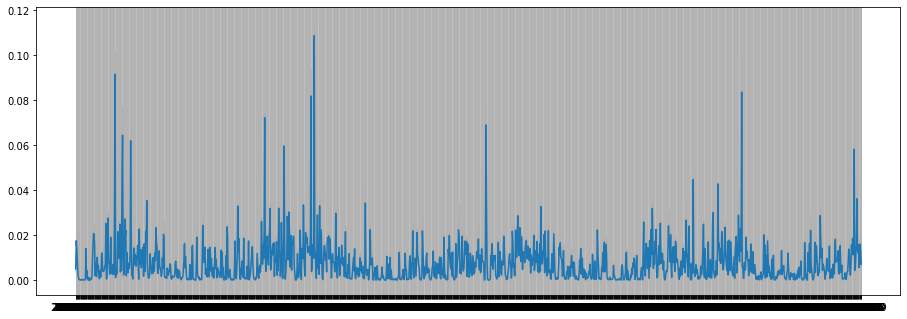

In [17]:
#Make lists with +/- SD
plus_error = [x + y for x,y in zip(tp_mean, tp_stddev)]
minus_error = [x - y for x,y in zip(tp_mean, tp_stddev)]

plt.axes([2, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')
plt.fill_between(icdates, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
plt.plot(icdates, tp_mean, label='tp')

In [18]:
def plot_mean_stddev(var_mean, var_stddev, var_name):
    #Make lists with +/- SD
    plus_error = [x + y for x,y in zip(var_mean, var_stddev)]
    minus_error = [x - y for x,y in zip(var_mean, var_stddev)]

    plt.axes([2, 0, 2, 1])
    plt.grid(b = True, which = 'major', axis = 'x')
    plt.fill_between(icdates, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
    plt.plot(icdates, var_mean, label=var_name)
    plt.legend(loc = "upper right")

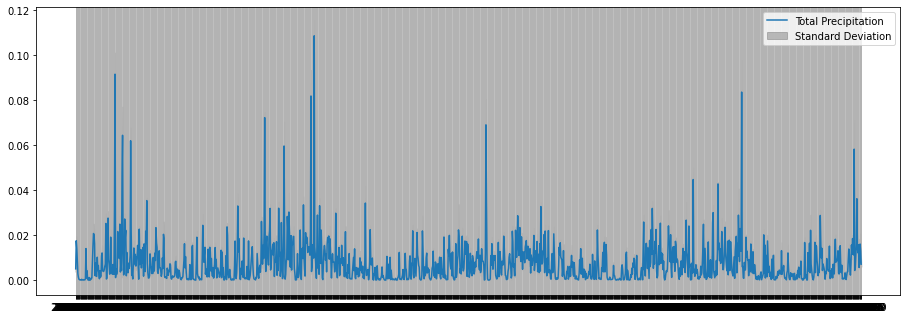

In [19]:
plot_mean_stddev(tp_mean, tp_stddev, var_name="Total Precipitation")

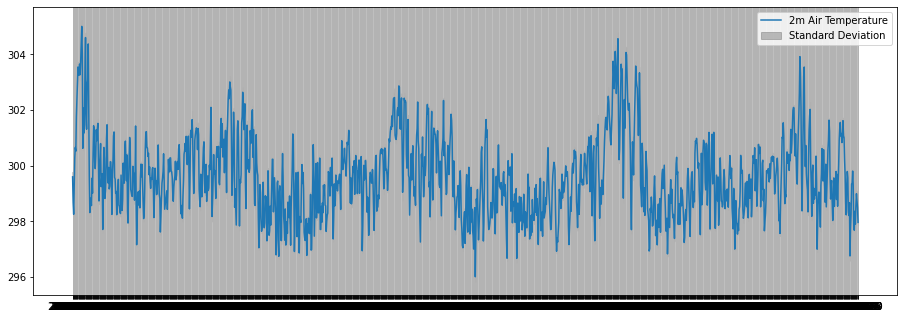

In [20]:
plot_mean_stddev(t2m_mean, t2m_stddev, var_name="2m Air Temperature")

In [ ]:
# accumulate variables for Growing Degree Days calculation 
start_date = ee.Date('2016-01-01', 'UTC')
def maccum_byYear(y):
    def maccum_byMonth(m):
        return (ic
                .filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRage(m, m, 'month'))
                .
            )

In [33]:
start_date = ee.Date('2016-01-01', 'UTC')
new_date = start_date.advance(2, 'month')
#print(start_date)
print(start_date, new_date)

ee.Date({
  "functionInvocationValue": {
    "functionName": "Date",
    "arguments": {
      "timeZone": {
        "constantValue": "UTC"
      },
      "value": {
        "constantValue": "2016-01-01"
      }
    }
  }
}) ee.Date({
  "functionInvocationValue": {
    "functionName": "Date.advance",
    "arguments": {
      "date": {
        "functionInvocationValue": {
          "functionName": "Date",
          "arguments": {
            "timeZone": {
              "constantValue": "UTC"
            },
            "value": {
              "constantValue": "2016-01-01"
            }
          }
        }
      },
      "delta": {
        "constantValue": 2
      },
      "unit": {
        "constantValue": "month"
      }
    }
  }
})


In [38]:
print(ee.Date)

<class 'ee.ee_date.Date'>
